<a href="https://colab.research.google.com/github/romqn1999/Predict-price-after-pattern/blob/model-classification/Classify_price_after_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from google.colab import files
uploaded = files.upload()

Saving ZM_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv to ZM_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Saving Z_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv to Z_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Saving Y_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv to Y_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Saving XPEV_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv to XPEV_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Saving XOM_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv to XOM_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Saving X_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv to X_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Saving WMT_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv to WMT_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Savi

## Import packages

In [3]:
import math
import matplotlib.pyplot as plt
import keras
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from keras.optimizers import Adagrad, Adadelta, RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

## Get data at pattern for training & testing

In [4]:
import io
import pandas as pd

price_patterns_df = pd.DataFrame()
for filename in uploaded.keys():
    print(filename)
    if 'double_top_data_patterns.csv' not in filename:
    # if 'data_patterns.csv' not in filename:
        print('Skipping file', filename)
        continue
    df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')),
                     header=None)
    price_patterns_df = price_patterns_df.append(df)

price_patterns_df = price_patterns_df.sample(frac=1).reset_index(drop=True)
price_patterns_df

ZM_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Z_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Y_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
XPEV_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
XOM_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
X_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
WMT_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
WFC_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
W_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
VZ_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
VXRT_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
VICI_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
VIAC_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
V_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
TSLA_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
T_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,101.000000,96.000000,92.500000,77.250000,67.500000,74.000000,74.000000,66.250000,61.500000,74.000000,66.500000,66.000000,64.500000,65.500000,67.000000,62.250000,60.750000,59.250000,58.000000,61.750000,71.750000,71.000000,74.250000,73.500000,75.750000,77.250000,75.000000,79.750000,77.500000,74.500000,76.500000
1,46.889999,47.049999,47.110001,46.799999,46.320000,46.990002,46.639999,45.700001,45.689999,46.650002,46.980000,47.270000,46.730000,47.240002,47.520000,47.660000,47.750000,47.639999,46.480000,46.950001,46.750000,47.480000,49.169998,48.779999,49.299999,49.680000,49.160000,49.790001,49.930000,49.139999,49.799999
2,5.200000,5.100000,4.750000,4.990000,4.910000,4.850000,4.950000,4.910000,4.780000,4.860000,4.960000,4.930000,5.090000,5.300000,5.330000,5.600000,5.880000,5.790000,5.840000,5.790000,5.380000,5.360000,5.170000,6.170000,6.050000,5.970000,5.790000,5.730000,5.410000,5.080000,4.900000
3,4972.000000,4840.000000,5148.000000,5060.000000,4884.000000,4950.000000,4906.000000,5016.000000,4466.000000,4598.000000,4708.000000,4620.000000,4840.000000,4774.000000,4906.000000,5038.000000,5104.000000,5126.000000,5038.000000,5104.000000,5060.000000,5038.000000,5060.000000,4862.000000,5016.000000,4884.000000,5060.000000,5016.000000,4906.000000,4532.000000,4598.000000
4,103.309998,104.870003,100.370003,101.830002,102.080002,111.050003,107.529999,105.980003,109.169998,116.699997,120.330002,119.540001,117.669998,118.589996,118.449997,119.529999,114.660004,113.300003,115.790001,116.750000,111.970001,107.250000,115.139999,112.870003,116.419998,119.720001,117.489998,116.669998,114.510002,110.309998,108.360001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5642,4.350000,4.350000,4.350000,4.050000,3.900000,3.900000,3.600000,3.750000,3.450000,3.600000,3.600000,3.600000,3.750000,4.200000,4.050000,3.750000,3.900000,3.900000,4.050000,3.970000,4.990000,4.610000,4.850000,4.580000,3.950000,3.950000,4.340000,4.490000,4.670000,3.950000,4.000000
5643,43.259998,42.290001,42.950001,42.130001,42.090000,42.450001,42.580002,43.020000,43.410000,43.639999,43.610001,44.189999,44.360001,44.029999,44.189999,44.610001,44.580002,44.799999,45.240002,44.889999,44.840000,44.770000,44.900002,44.990002,44.700001,44.980000,45.220001,45.310001,44.799999,44.349998,43.990002
5644,20.980768,20.769232,20.355768,20.769232,21.134615,22.211538,22.355768,22.788462,22.115385,22.115385,22.596153,22.221153,21.692308,22.163462,23.211538,23.336538,23.894232,23.605768,23.519232,23.596153,23.317308,23.317308,23.605768,23.500000,23.509615,23.846153,23.798077,23.807692,23.326923,23.057692,23.221153
5645,21.830000,21.920000,20.930000,21.450001,23.040001,21.940001,21.850000,22.240000,22.070000,22.740000,23.530001,23.900000,23.520000,23.590000,23.709999,23.590000,23.610001,23.400000,23.320000,22.760000,22.299999,22.250000,22.260000,21.350000,21.270000,21.000000,22.299999,21.639999,22.440001,21.570000,21.330000


In [5]:
#@title Separate into input and output columns: Get data: X and y

X_df = price_patterns_df[price_patterns_df.columns[:-1]]
y_df = price_patterns_df[price_patterns_df.columns[-1:]]
print(X_df)
print(y_df)

X_data = X_df.values
y_data = y_df.values
print(X_data)
print(y_data)

               0            1   ...           28           29
0      101.000000    96.000000  ...    77.500000    74.500000
1       46.889999    47.049999  ...    49.930000    49.139999
2        5.200000     5.100000  ...     5.410000     5.080000
3     4972.000000  4840.000000  ...  4906.000000  4532.000000
4      103.309998   104.870003  ...   114.510002   110.309998
...           ...          ...  ...          ...          ...
5642     4.350000     4.350000  ...     4.670000     3.950000
5643    43.259998    42.290001  ...    44.799999    44.349998
5644    20.980768    20.769232  ...    23.326923    23.057692
5645    21.830000    21.920000  ...    22.440001    21.570000
5646   784.400024   782.906006  ...   812.539978   766.650024

[5647 rows x 30 columns]
               30
0       76.500000
1       49.799999
2        4.900000
3     4598.000000
4      108.360001
...           ...
5642     4.000000
5643    43.990002
5644    23.221153
5645    21.330000
5646   791.500000

[5647 rows x 

In [6]:
def get_direction(pre, cur, min_change=1):
    if abs(pre - cur) < min_change:
        return 0
    else:
        if pre < cur:
            return 1
        else:
            return -1

def y_preice_to_y_label(X, y, min_change=0):
    assert len(X) == len(y)
    n = len(y)
    y_label = np.array([get_direction(X[i][-1], y[i], min_change) for i in range(n)])
    # Convert from {-1; 0; 1} to label {0; 1; 2}
    y_label = y_label + 1
    return y_label

In [7]:
#@title Preprocess & split data for train model
# Train, test split
train_ratio = 0.8 #@param {type:"number"}
if train_ratio < 0 or  train_ratio > 1:
    train_ratio = 0.8
n_data = len(X_data)
n_train = int(train_ratio * n_data)
n_test = n_data - n_train
# Feature Scaling
scale_method = "MinMax" #@param ["None", "MinMax"]
min_price_change = 0 #@param {type:"number"}

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=train_ratio, random_state=7)
# X_train, y_train = X_data[: n_train], y_data[: n_train]
y_train_label = y_preice_to_y_label(X_train, y_train, min_price_change)
y_train_categorical = to_categorical(y_train_label, num_classes=3)
# X_test, y_test = X_data[n_train:], y_data[n_train:]
y_test_label = y_preice_to_y_label(X_test, y_test, min_price_change)
y_test_categorical = to_categorical(y_test_label, num_classes=3)
if scale_method == 'MinMax':
    sc_train = MinMaxScaler(feature_range = (0, 1))
    X_train_scaled = sc_train.fit_transform(X_train.T).T
    y_train_scaled = sc_train.transform(y_train.T).T
    y_train_scaled_label = y_preice_to_y_label(X_train_scaled, y_train_scaled, min_price_change)
    y_train_scaled_categorical = to_categorical(y_train_scaled_label, num_classes=3)
    sc_test = MinMaxScaler(feature_range = (0, 1))
    X_test_scaled = sc_test.fit_transform(X_test.T).T
    y_test_scaled = sc_test.transform(y_test.T).T
    y_test_scaled_label = y_preice_to_y_label(X_test_scaled, y_test_scaled, min_price_change)
    y_test_scaled_categorical = to_categorical(y_test_scaled_label, num_classes=3)
    # X_train, y_train = X_train_scaled, y_train_scaled
    # X_test, y_test = X_test_scaled, y_test_scaled
print(X_train.shape, y_train.shape)
print(X_train_scaled.shape, y_train_scaled.shape)
print(y_train_categorical.shape)
print(y_train_scaled_categorical.shape)
print(X_test.shape, y_test.shape)
print(X_test_scaled.shape, y_test_scaled.shape)
print(y_test_categorical.shape)
print(y_test_scaled_categorical.shape)

# print(X_train)
# print(y_train)

(4517, 30) (4517, 1)
(4517, 30) (4517, 1)
(4517, 3)
(4517, 3)
(1130, 30) (1130, 1)
(1130, 30) (1130, 1)
(1130, 3)
(1130, 3)


## LSTM model

### Build model

In [8]:
#@title Build & fit model
lstm_units = 50 #@param {type:"integer"}
dropout_prob = 0.5 #@param {type:"number"}
epochs = 10000 #@param {type:"integer"}
batch_size = 32768 #@param {type:"integer"}



### Train model

Epoch 1/10000
1/1 [==============================] - 30s 30s/step - loss: 1.1006 - accuracy: 0.2849 - val_loss: 1.0895 - val_accuracy: 0.5018

Epoch 00001: val_accuracy improved from -inf to 0.50177, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 2/10000
1/1 [==============================] - 0s 237ms/step - loss: 1.0894 - accuracy: 0.5021 - val_loss: 1.0760 - val_accuracy: 0.5018

Epoch 00002: val_accuracy did not improve from 0.50177
Epoch 3/10000
1/1 [==============================] - 0s 210ms/step - loss: 1.0769 - accuracy: 0.5017 - val_loss: 1.0598 - val_accuracy: 0.5018

Epoch 00003: val_accuracy did not improve from 0.50177
Epoch 4/10000
1/1 [==============================] - 0s 192ms/step - loss: 1.0613 - accuracy: 0.5014 - val_loss: 1.0385 - val_accuracy: 0.5018

Epoch 00004: val_accuracy did not improve from 0.50177
Epoch 5/10000
1/1 [==============================] - 0s 178ms/step - loss: 1.0409 - accuracy: 0.5014 - val_loss: 1.0104 - val_accuracy: 0.5018

Epoch 00005: val_accuracy did not improve from 0.50177
Epoch 6/10000
1/1 [==============================] - 0s 174ms/step - loss: 1.0132 - accuracy: 0.5037 - val_loss: 0.9739 - val_accuracy: 0.5018

Epoch 00006: val_accuracy did not improve from 0.50177
Epoch

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 15/10000
1/1 [==============================] - 0s 239ms/step - loss: 0.7394 - accuracy: 0.4928 - val_loss: 0.7014 - val_accuracy: 0.4982

Epoch 00015: val_accuracy did not improve from 0.51858
Epoch 16/10000
1/1 [==============================] - 0s 210ms/step - loss: 0.7365 - accuracy: 0.4986 - val_loss: 0.6996 - val_accuracy: 0.4982

Epoch 00016: val_accuracy did not improve from 0.51858
Epoch 17/10000
1/1 [==============================] - 0s 193ms/step - loss: 0.7292 - accuracy: 0.5059 - val_loss: 0.6972 - val_accuracy: 0.4982

Epoch 00017: val_accuracy did not improve from 0.51858
Epoch 18/10000
1/1 [==============================] - 0s 177ms/step - loss: 0.7280 - accuracy: 0.4904 - val_loss: 0.6967 - val_accuracy: 0.5018

Epoch 00018: val_accuracy did not improve from 0.51858
Epoch 19/10000
1/1 [==============================] - 0s 176ms/step - loss: 0.7250 - accuracy: 0.4913 - val_loss: 0.7005 - val_accuracy: 0.5018

Epoch 00019: val_accuracy did not improve from 0.51858


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 1017/10000
1/1 [==============================] - 0s 245ms/step - loss: 0.6933 - accuracy: 0.5037 - val_loss: 0.6931 - val_accuracy: 0.5009

Epoch 01017: val_accuracy did not improve from 0.52301
Epoch 1018/10000
1/1 [==============================] - 0s 220ms/step - loss: 0.6929 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.4982

Epoch 01018: val_accuracy did not improve from 0.52301
Epoch 1019/10000
1/1 [==============================] - 0s 198ms/step - loss: 0.6938 - accuracy: 0.4913 - val_loss: 0.6930 - val_accuracy: 0.4991

Epoch 01019: val_accuracy did not improve from 0.52301
Epoch 1020/10000
1/1 [==============================] - 0s 187ms/step - loss: 0.6937 - accuracy: 0.4930 - val_loss: 0.6930 - val_accuracy: 0.5035

Epoch 01020: val_accuracy did not improve from 0.52301
Epoch 1021/10000
1/1 [==============================] - 0s 181ms/step - loss: 0.6933 - accuracy: 0.4975 - val_loss: 0.6930 - val_accuracy: 0.5027

Epoch 01021: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 1043/10000
1/1 [==============================] - 0s 177ms/step - loss: 0.6934 - accuracy: 0.4997 - val_loss: 0.6929 - val_accuracy: 0.5133

Epoch 01043: val_accuracy did not improve from 0.52389
Epoch 1044/10000
1/1 [==============================] - 0s 179ms/step - loss: 0.6929 - accuracy: 0.5130 - val_loss: 0.6929 - val_accuracy: 0.5071

Epoch 01044: val_accuracy did not improve from 0.52389
Epoch 1045/10000
1/1 [==============================] - 0s 183ms/step - loss: 0.6937 - accuracy: 0.4944 - val_loss: 0.6929 - val_accuracy: 0.5080

Epoch 01045: val_accuracy did not improve from 0.52389
Epoch 1046/10000
1/1 [==============================] - 0s 183ms/step - loss: 0.6932 - accuracy: 0.5065 - val_loss: 0.6929 - val_accuracy: 0.5080

Epoch 01046: val_accuracy did not improve from 0.52389
Epoch 1047/10000
1/1 [==============================] - 0s 176ms/step - loss: 0.6933 - accuracy: 0.4957 - val_loss: 0.6929 - val_accuracy: 0.5097

Epoch 01047: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Streaming output truncated to the last 5000 lines.
Epoch 1159/10000
1/1 [==============================] - 0s 186ms/step - loss: 0.6914 - accuracy: 0.5154 - val_loss: 0.6935 - val_accuracy: 0.5018

Epoch 01159: val_accuracy did not improve from 0.53186
Epoch 1160/10000
1/1 [==============================] - 0s 180ms/step - loss: 0.6924 - accuracy: 0.5127 - val_loss: 0.6936 - val_accuracy: 0.5000

Epoch 01160: val_accuracy did not improve from 0.53186
Epoch 1161/10000
1/1 [==============================] - 0s 177ms/step - loss: 0.6925 - accuracy: 0.5185 - val_loss: 0.6942 - val_accuracy: 0.5009

Epoch 01161: val_accuracy did not improve from 0.53186
Epoch 1162/10000
1/1 [==============================] - 0s 190ms/step - loss: 0.6919 - accuracy: 0.5130 - val_loss: 0.6948 - val_accuracy: 0.4973

Epoch 01162: val_accuracy did not improve from 0.53186
Epoch 1163/10000
1/1 [==============================] - 0s 177ms/step - loss: 0.6917 - accuracy: 0.5198 - val_loss: 0.6951 - val_accuracy: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Streaming output truncated to the last 5000 lines.
Epoch 08751: val_accuracy did not improve from 0.53540
Epoch 8752/10000
1/1 [==============================] - 0s 184ms/step - loss: 0.3011 - accuracy: 0.8397 - val_loss: 1.4981 - val_accuracy: 0.5142

Epoch 08752: val_accuracy did not improve from 0.53540
Epoch 8753/10000
1/1 [==============================] - 0s 184ms/step - loss: 0.3009 - accuracy: 0.8404 - val_loss: 1.4752 - val_accuracy: 0.5212

Epoch 08753: val_accuracy did not improve from 0.53540
Epoch 8754/10000
1/1 [==============================] - 0s 185ms/step - loss: 0.2846 - accuracy: 0.8479 - val_loss: 1.4723 - val_accuracy: 0.5204

Epoch 08754: val_accuracy did not improve from 0.53540
Epoch 8755/10000
1/1 [==============================] - 0s 196ms/step - loss: 0.2954 - accuracy: 0.8444 - val_loss: 1.4788 - val_accuracy: 0.5150

Epoch 08755: val_accuracy did not improve from 0.53540
Epoch 8756/10000
1/1 [==============================] - 0s 183ms/step - loss: 0.2916 -

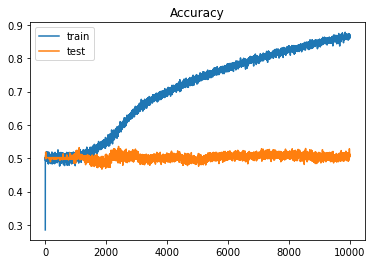

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


In [9]:
def train_lstm(X_train, y_train, X_test, y_test, lstm_units=50, dropout_prob=0.5, n_classes=3, epochs=6000, batch_size=32768):
    # We have now reshaped the data into the following format (#values, #time-steps, #1 dimensional output).
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], n_classes))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], n_classes))

    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True,
                input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_prob))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True))
    model.add(Dropout(dropout_prob))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True))
    model.add(Dropout(dropout_prob))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    # Adding the output layer
    # model.add(Dense(units=1))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Adam optimizer
    opt = Adam(learning_rate=0.0005, epsilon=1e-06, decay=1e-06)
    # # PiecewiseConstantDecay optimizer
    # boundaries = [200, 800, 2000, 4000]
    # values = [0.01, 0.001, 0.0005, 0.0001, 0.00001]
    # opt = keras.optimizers.schedules.PiecewiseConstantDecay(
    #     boundaries, values)

    checkpoint = ModelCheckpoint("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc", monitor='val_accuracy', verbose=2,
                                 save_best_only=True, mode='auto')

    # Compiling the RNN
    # model.compile(optimizer = opt, loss = 'mean_squared_error')
    # model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fitting the RNN to the Training set
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=batch_size,
                        callbacks=[checkpoint])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train)
    _, test_acc = model.evaluate(X_test, y_test)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    # plot loss during training
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

    return model

model = train_lstm(X_train_scaled, y_train_scaled_categorical,
                   X_test_scaled, y_test_scaled_categorical,
                   lstm_units=lstm_units, dropout_prob=dropout_prob, n_classes=3,
                   epochs=epochs, batch_size=batch_size)
model.save('/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest')

### Test model

In [10]:
def calc_confusion_matrix(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    cm = confusion_matrix(y_true_direction, y_pred_direction, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[-1, 0, 1])
    disp.plot()
    return cm

def calc_accuracy(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    return accuracy_score(y_true_direction, y_pred_direction)

In [11]:
# X_test = X_train
lstm_model = keras.models.load_model("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc")

In [12]:
#@title Define some params for make decision { run: "auto" }
min_price_change = 0 #@param {type:"number"}


In [13]:
y_pred = lstm_model.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1)))

In [14]:
y_test_scaled_categorical, y_pred

(array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], dtype=float32),
 array([[3.9968910e-03, 3.0504900e-06, 9.9600005e-01],
        [3.4920755e-01, 7.3257452e-06, 6.5078509e-01],
        [5.2788162e-01, 9.6319695e-07, 4.7211745e-01],
        ...,
        [4.7125536e-01, 4.7201132e-07, 5.2874416e-01],
        [1.9745448e-01, 4.7245903e-06, 8.0254078e-01],
        [4.6987274e-01, 2.9400863e-07, 5.3012693e-01]], dtype=float32))

confusion_matrix: [[206   0 357]
 [  0   0   0]
 [168   0 399]]
acc: 0.5353982300884956
confusion_matrix: [[ 955    0 1286]
 [   0    0    0]
 [ 505    0 1771]]
acc: 0.603497896834182


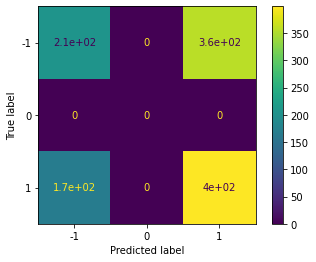

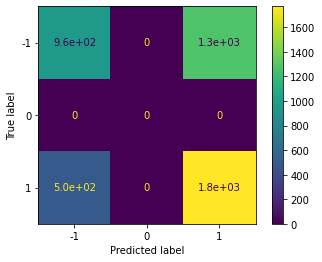

In [15]:
def show_val_res_label(y_true_label, y_pred_label):
    y_true_label = y_true_label - 1
    y_pred_label = y_pred_label - 1
    cm = confusion_matrix(y_true_label, y_pred_label, labels=[-1, 0, 1])
    print('confusion_matrix:', cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[-1, 0, 1])
    disp.plot()

    acc = accuracy_score(y_true_label, y_pred_label)
    print('acc:', acc)

def show_val_res_categorical(y_true, y_pred):
    y_true_label = np.argmax(y_true, axis=1)
    y_pred_label = np.argmax(y_pred, axis=1)
    show_val_res_label(y_true_label, y_pred_label)

show_val_res_categorical(y_test_scaled_categorical, y_pred)
show_val_res_categorical(y_train_scaled_categorical, lstm_model.predict(np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))))

## XGBoost model

### Build model

In [16]:
#@title Build model
seed = 100 #@param {type:"integer"}
n_estimators = 100 #@param {type:"integer"}
max_depth = 3 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
min_child_weight = 0 #@param {type:"number"}
subsample = 1 #@param {type:"number"}
colsample_bytree = 1 #@param {type:"number"}
colsample_bylevel = 1 #@param {type:"number"}
gamma = 0 #@param {type:"number"}
from xgboost import XGBClassifier

# xgbmodel = XGBClassifier(seed=seed,
#                         n_estimators=n_estimators,
#                         max_depth=max_depth,
#                         learning_rate=learning_rate,
#                         min_child_weight=min_child_weight,
#                         subsample=subsample,
#                         colsample_bytree=colsample_bytree,
#                         colsample_bylevel=colsample_bylevel,
#                         gamma=gamma)
xgbmodel = XGBClassifier()

### Train the model

In [17]:
xgbmodel.fit(X_train_scaled, y_train_scaled_label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Test model

In [18]:
y_pred = xgbmodel.predict(X_test_scaled)

confusion_matrix: [[257   0 306]
 [  0   0   0]
 [269   0 298]]
acc: 0.4911504424778761


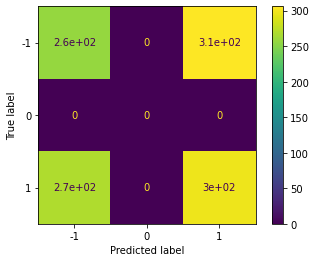

In [19]:
show_val_res_label(y_test_scaled_label, y_pred)